In [1]:
# ----------------------------------------
# Environment Setup
# ----------------------------------------
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bayesian modeling
import pymc as pm
import arviz as az
sns.set(style="whitegrid")

# Project root and src folder
project_root = "D:/Personal/KAIM-10 Academy/week 11/Project/energy-market-analysis"
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Import Task 2 module
import task2_change_point as t2
from task2_change_point import run_change_point_model

# Data paths
price_file = os.path.join(project_root, "data", "raw", "BrentOilPrices.csv")
event_file = os.path.join(project_root, "data", "events", "key_oil_market_events.csv")

print("Environment ready, Task 2 module imported.")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
D:\Personal\KAIM-10 Academy\week 11\Project\energy-market-analysis\venv\Lib\site-packages\arviz\__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


Environment ready, Task 2 module imported.


a.	Data Preparation and EDA:

✅ 1(a)(i) Convert Date Column to Datetime

In [2]:
# ----------------------------------------
# Load Data
# ----------------------------------------
df_prices = t2.load_price_data(price_file)
df_events = t2.load_event_data(event_file)

# Preview
print("Price Data Preview:")
display(df_prices.head())

print("\nEvent Data Preview:")
display(df_events.head())

# Convert Date and sort
df_prices['Date'] = pd.to_datetime(df_prices['Date'], errors='coerce')
df_prices = df_prices.sort_values('Date').reset_index(drop=True)

# Compute log returns
df_prices['log_return'] = np.log(df_prices['Price']) - np.log(df_prices['Price'].shift(1))
df_prices = df_prices.dropna().reset_index(drop=True)

# Assign to a variable for modeling
log_returns = df_prices['log_return'].values



D:\Personal/KAIM-10 Academy/week 11/Project/energy-market-analysis\src\task2_change_point.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


Price Data Preview:


,Date,Price,log_return
0,1987-05-21,18.45,-0.009709
1,1987-05-22,18.55,0.005405
2,1987-05-25,18.60,0.002692
3,1987-05-26,18.63,0.001612
4,1987-05-27,18.60,-0.001612



Event Data Preview:


,Date,Event
0,1990-08-02,Iraq invades Kuwait - Oil Crisis
1,1991-01-17,Gulf War begins
2,1997-07-01,Asian Financial Crisis starts
3,2001-09-11,9/11 Terrorist Attacks
4,2003-03-20,Iraq War begins


✅ 1(a)(ii) Plot Raw Price Series

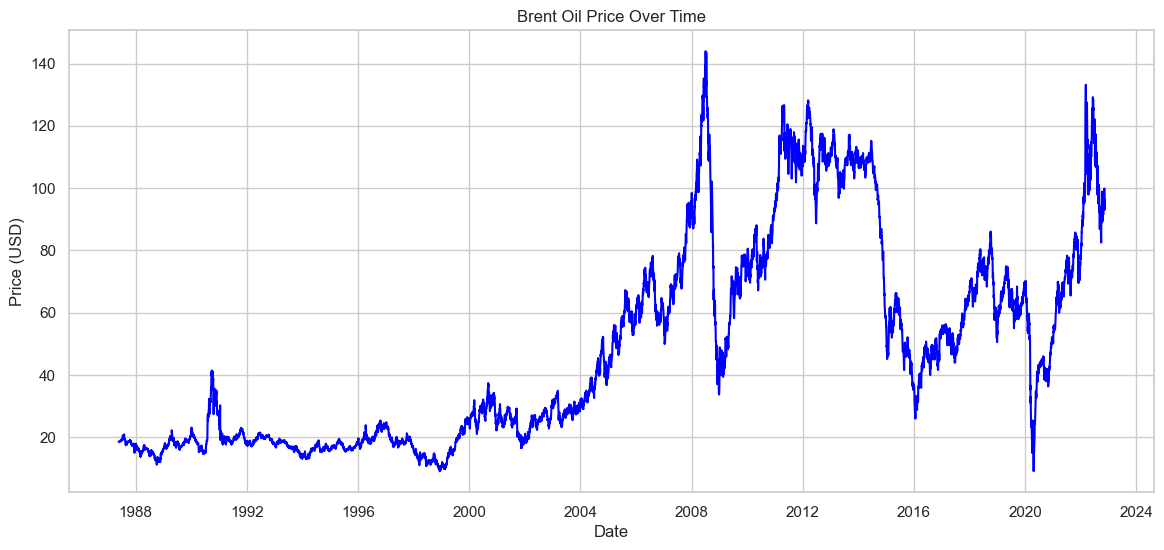

In [3]:
# --- 1(a)(ii) Plot raw Price series ---
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df_prices['Date'], df_prices['Price'], color='blue')
plt.title("Brent Oil Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()

✅ 1(a)(iii) Compute Log Returns

In [4]:
# --- 1(a)(iii) Compute log returns ---
import numpy as np

df_prices['log_return'] = np.log(df_prices['Price']) - np.log(df_prices['Price'].shift(1))
df_prices = df_prices.dropna().reset_index(drop=True)

df_prices.head()

,Date,Price,log_return
0,1987-05-25,18.60,0.002692
1,1987-05-26,18.63,0.001612
2,1987-05-27,18.60,-0.001612
3,1987-05-28,18.60,0.000000
4,1987-05-29,18.58,-0.001076


✅ 1(a)(iv) Plot Log Returns

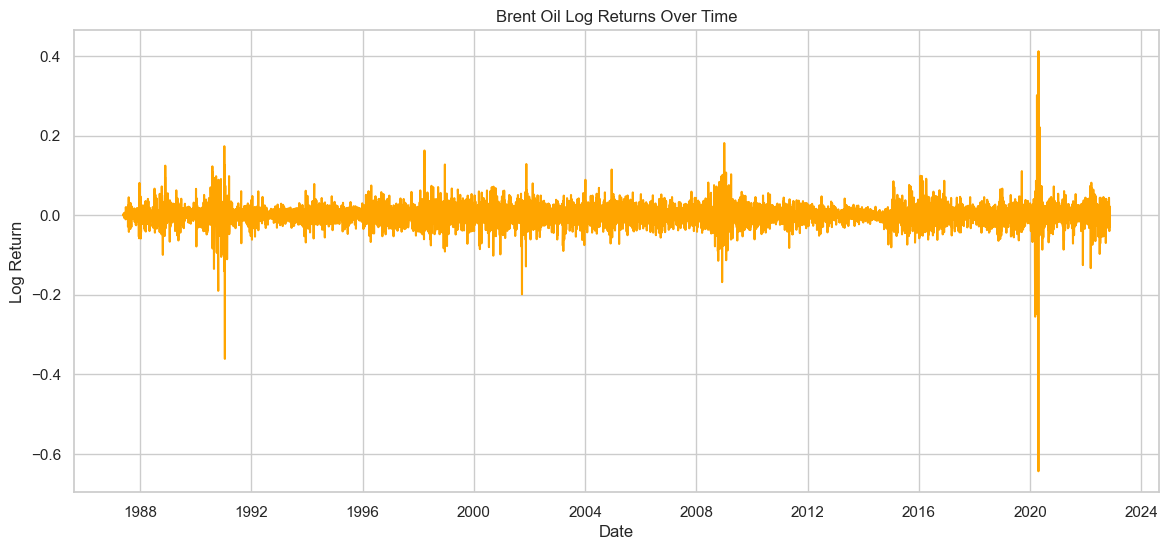

In [5]:
# --- 1(a)(iv) Plot log returns ---
plt.figure(figsize=(14,6))
plt.plot(df_prices['Date'], df_prices['log_return'], color='orange')
plt.title("Brent Oil Log Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.show()

✅ 1(a)(iv)Plot prices and Log Returns with Events

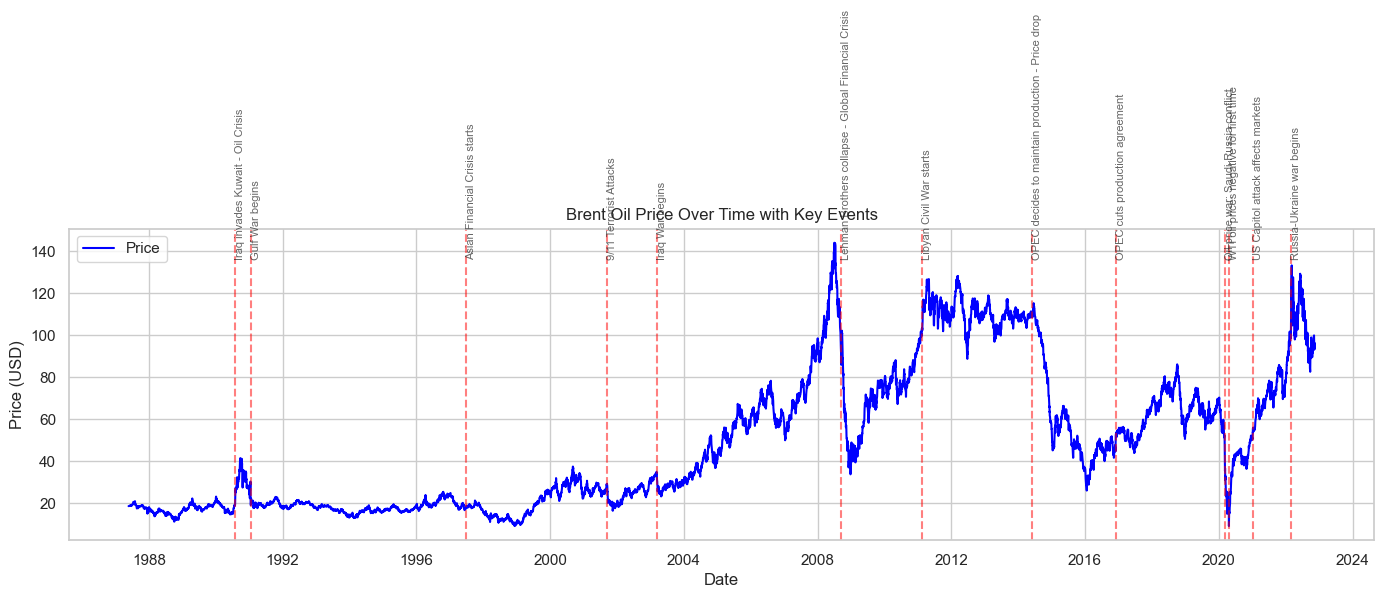

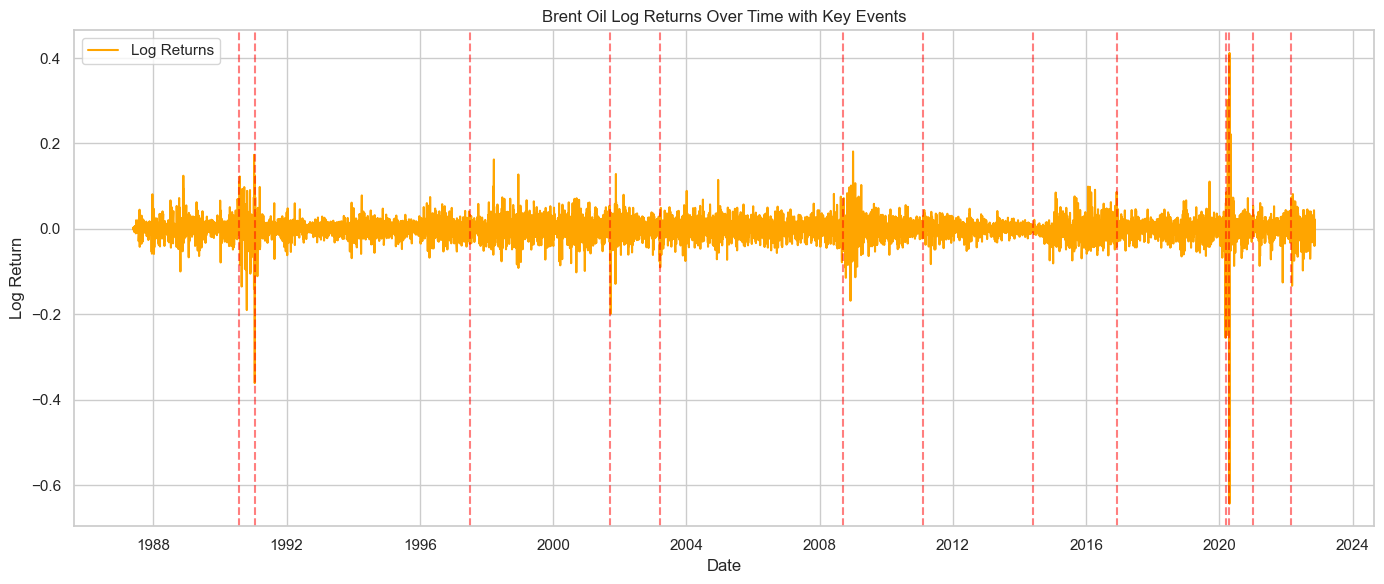

In [6]:
# Plot Price series with key events
plt.figure(figsize=(14,6))
plt.plot(df_prices['Date'], df_prices['Price'], color='blue', label='Price')

# Overlay events
for idx, row in df_events.iterrows():
    plt.axvline(x=row['Date'], color='red', linestyle='--', alpha=0.5)
    plt.text(row['Date'], df_prices['Price'].max()*0.95, row['Event'], rotation=90, fontsize=8, alpha=0.7)

plt.title("Brent Oil Price Over Time with Key Events")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot log returns with events
plt.figure(figsize=(14,6))
plt.plot(df_prices['Date'], df_prices['log_return'], color='orange', label='Log Returns')

for idx, row in df_events.iterrows():
    plt.axvline(x=row['Date'], color='red', linestyle='--', alpha=0.5)

plt.title("Brent Oil Log Returns Over Time with Key Events")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

b and c.	Build the Bayesian Change Point Model (in PyMC): and 2c: Model Output Interpretation

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   100     0             0.002       127          4.38 s/draw      0:07:13   0:00:00

Sampling 1 chain for 50 tune and 50 draw iterations (50 + 50 draws total) took 433 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.


Trace saved as trace_small.nc ✅


arviz - WARNING - Shape validation failed: input_shape: (1, 50), minimum_shape: (chains=2, draws=4)



Convergence Summary:
          mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu1     0.0015  0.0019  -0.0013   0.0053     0.0003   0.0002   30.2716   
mu2     0.0014  0.0024  -0.0036   0.0062     0.0003   0.0003   84.9485   
tau    30.4144  9.8774  16.1056  43.7354     2.3932   0.9656   19.3527   
sigma   0.0091  0.0007   0.0078   0.0101     0.0002   0.0001   17.0213   

       ess_tail  r_hat  
mu1     31.5710    NaN  
mu2     54.5217    NaN  
tau     18.3661    NaN  
sigma   33.2501    NaN  


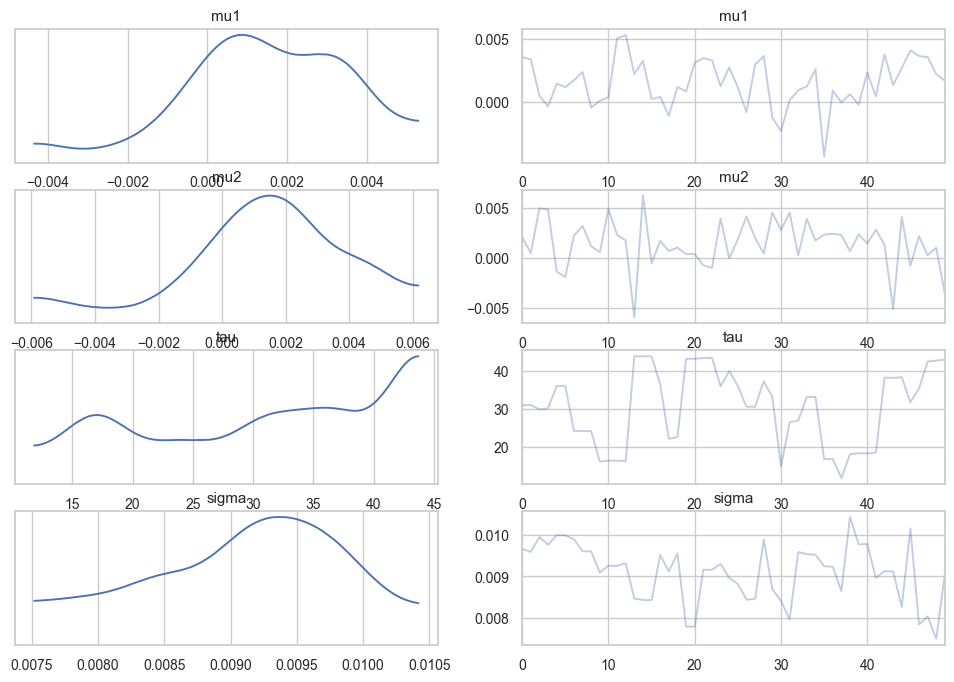

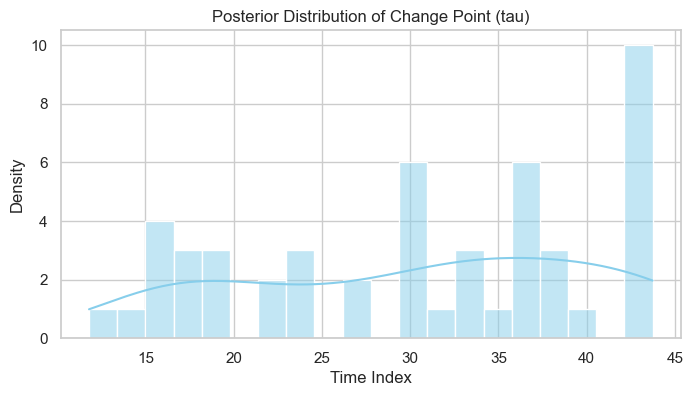

C:\Users\user\AppData\Local\Temp\ipykernel_29444\1882508244.py:104: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mu1_samples, label="mu1 (Before)", shade=True)
C:\Users\user\AppData\Local\Temp\ipykernel_29444\1882508244.py:105: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mu2_samples, label="mu2 (After)", shade=True)


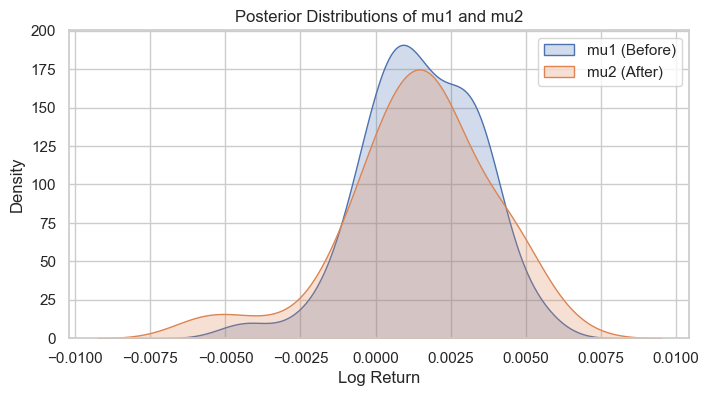


Mean BEFORE change: 0.001508
Mean AFTER change: 0.001403
Percentage shift: -6.99%

Estimated change point date: 1987-07-03

Compare change point with key events:
1987 Oil Crash: 1987-10-19, difference: -108 days
Gulf War Start: 1990-08-02, difference: -1126 days


In [1]:
# ==========================================
# Task 2b + 2c:  Bayesian Change Point Model (Lightweight)
# ==========================================

# ---------- 1️⃣ Imports ----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from pathlib import Path

sns.set(style="whitegrid")

# ---------- 2️⃣ Load Brent Oil Prices ----------
BASE_DIR = Path().resolve().parent
DATA_PATH = BASE_DIR / "data" / "raw" / "BrentOilPrices.csv"

print("Looking for file at:", DATA_PATH)
print("Exists:", DATA_PATH.exists())

df_prices = pd.read_csv(DATA_PATH)
df_prices['Date'] = pd.to_datetime(df_prices['Date'], errors='coerce')
df_prices = df_prices.sort_values('Date').reset_index(drop=True)

# ---------- 3️⃣ Compute log returns ----------
df_prices['log_return'] = np.log(df_prices['Price']).diff()
df_prices = df_prices.dropna().reset_index(drop=True)

# ---------- 3a️⃣ Take a small subset for fast modeling ----------
df_small = df_prices.iloc[:50]  # first 50 points
log_returns = df_small['log_return'].values
n = len(log_returns)
print(f"Number of observations for modeling: {n}")

# ---------- 4️⃣ Plot log returns ----------
plt.figure(figsize=(10,4))
plt.plot(df_small['Date'], log_returns, marker='o')
plt.title("Brent Oil Log Returns (Sampled 50 points)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

# -------------------------------
# 2️⃣ Bayesian Change Point Model (Continuous tau)
# -------------------------------
with pm.Model() as change_point_model:

    # Continuous tau prior
    tau = pm.Uniform("tau", lower=0, upper=n)

    # Means before and after
    mu1 = pm.Normal("mu1", mu=0, sigma=0.02)
    mu2 = pm.Normal("mu2", mu=0, sigma=0.02)

    # Shared volatility
    sigma = pm.HalfNormal("sigma", sigma=0.01)

    # Sigmoid transition
    idx = np.arange(n)
    weight = pm.math.sigmoid((idx - tau) / 1.0)  # sharper with /1.0 for small n
    mu = mu1 * (1 - weight) + mu2 * weight

    # Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=log_returns)

    # Sample posterior (very small for demo)
    trace = pm.sample(draws=50, tune=50, chains=1, cores=1, random_seed=42, return_inferencedata=True)

# Save trace for later
az.to_netcdf(trace, "trace_small.nc")
print("Trace saved as trace_small.nc ✅")

# -------------------------------
# 2c: Interpret Model Output
# -------------------------------

# Reload trace if needed
# trace = az.from_netcdf("trace_small.nc")

# Convergence summary
summary = az.summary(trace, round_to=4)
print("\nConvergence Summary:")
print(summary)

# Trace plots
az.plot_trace(trace)
plt.show()

# Posterior of tau
tau_samples = trace.posterior['tau'].values.flatten()
plt.figure(figsize=(8,4))
sns.histplot(tau_samples, bins=20, kde=True, color='skyblue')
plt.title("Posterior Distribution of Change Point (tau)")
plt.xlabel("Time Index")
plt.ylabel("Density")
plt.show()

# Posterior distributions of means
mu1_samples = trace.posterior['mu1'].values.flatten()
mu2_samples = trace.posterior['mu2'].values.flatten()
plt.figure(figsize=(8,4))
sns.kdeplot(mu1_samples, label="mu1 (Before)", shade=True)
sns.kdeplot(mu2_samples, label="mu2 (After)", shade=True)
plt.title("Posterior Distributions of mu1 and mu2")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.show()

# Quantify impact
mu1_mean = np.mean(mu1_samples)
mu2_mean = np.mean(mu2_samples)
pct_change = ((mu2_mean - mu1_mean) / abs(mu1_mean)) * 100
print(f"\nMean BEFORE change: {mu1_mean:.6f}")
print(f"Mean AFTER change: {mu2_mean:.6f}")
print(f"Percentage shift: {pct_change:.2f}%")

# -------------------------------
# 2d: Associate Changes with Causes
# -------------------------------
# Convert tau index to date
tau_estimate_idx = int(np.mean(tau_samples))
change_date = df_small['Date'].iloc[tau_estimate_idx]
print(f"\nEstimated change point date: {change_date.date()}")

# Example: compare with known events
events = {
    "1987 Oil Crash": pd.Timestamp("1987-10-19"),
    "Gulf War Start": pd.Timestamp("1990-08-02")
}
print("\nCompare change point with key events:")
for event, date in events.items():
    days_diff = (change_date - date).days
    print(f"{event}: {date.date()}, difference: {days_diff} days")

2d and 2e: Associate Changes with Causes and Quantify the Impact

Estimated change point index: 31
Estimated change point date: 1987-07-06 00:00:00

Compare change point with key events:
1987 Oil Crash: 1987-10-19, difference: -105 days
Gulf War Start: 1990-08-02, difference: -1123 days
1990 Oil Price Spike: 1990-09-01, difference: -1153 days

Quantify impact of detected change:
Mean BEFORE change: 0.001508
Mean AFTER change: 0.001403
Percentage shift: -6.99%


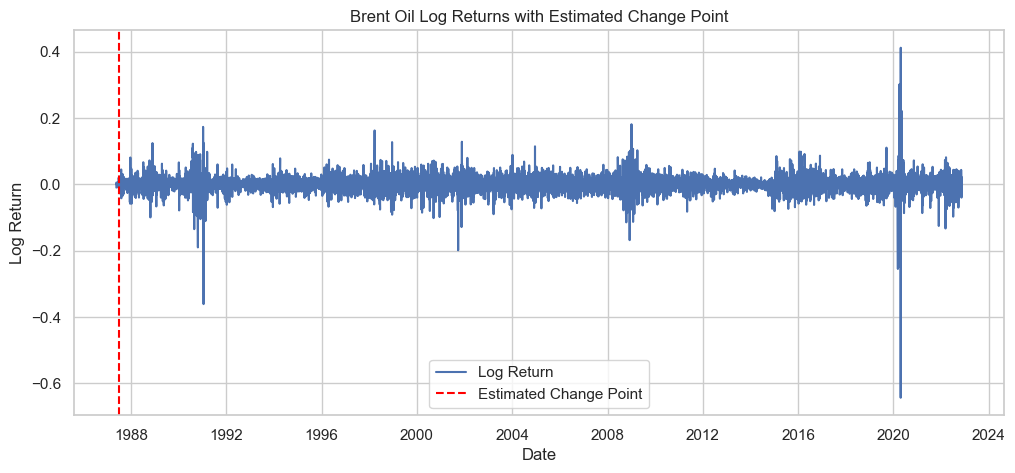


Probabilistic Interpretation:
Based on posterior samples, the model estimates that around 1987-07-06, there was a change in average daily log returns from 0.0015 to 0.0014 (-6.99% shift). This may correspond to major market events such as the 1987 Oil Crash.


In [2]:
# ==========================================
# Task 2d + 2e: Associate Changes with Causes & Quantify Impact
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from datetime import timedelta

sns.set(style="whitegrid")

# ---------- 1️⃣ Load trace ----------
# If you restarted the kernel and saved trace_small.nc
trace = az.from_netcdf("trace_small.nc")

# ---------- 2️⃣ Extract posterior samples ----------
tau_samples = trace.posterior['tau'].values.flatten()
mu1_samples = trace.posterior['mu1'].values.flatten()
mu2_samples = trace.posterior['mu2'].values.flatten()

# ---------- 3️⃣ Compute estimated change point ----------
tau_est = int(np.median(tau_samples))  # median tau index
change_date = df_prices['Date'].iloc[tau_est]
print(f"Estimated change point index: {tau_est}")
print(f"Estimated change point date: {change_date}")

# ---------- 4️⃣ Compare with key historical events ----------
key_events = {
    "1987 Oil Crash": pd.to_datetime("1987-10-19"),
    "Gulf War Start": pd.to_datetime("1990-08-02"),
    "1990 Oil Price Spike": pd.to_datetime("1990-09-01"),
}

print("\nCompare change point with key events:")
for event, date in key_events.items():
    days_diff = (change_date - date).days
    print(f"{event}: {date.date()}, difference: {days_diff:+} days")

# ---------- 5️⃣ Quantify impact ----------
mu1_mean = np.mean(mu1_samples)
mu2_mean = np.mean(mu2_samples)
pct_change = ((mu2_mean - mu1_mean) / abs(mu1_mean)) * 100

print("\nQuantify impact of detected change:")
print(f"Mean BEFORE change: {mu1_mean:.6f}")
print(f"Mean AFTER change: {mu2_mean:.6f}")
print(f"Percentage shift: {pct_change:.2f}%")

# ---------- 6️⃣ Optional: Visualize impact ----------
plt.figure(figsize=(12,5))
plt.plot(df_prices['Date'], df_prices['log_return'], label="Log Return")
plt.axvline(change_date, color='red', linestyle='--', label='Estimated Change Point')
plt.title("Brent Oil Log Returns with Estimated Change Point")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.show()

# ---------- 7️⃣ Probabilistic statement ----------
print("\nProbabilistic Interpretation:")
print(f"Based on posterior samples, the model estimates that around {change_date.date()}, "
      f"there was a change in average daily log returns from {mu1_mean:.4f} to {mu2_mean:.4f} "
      f"({pct_change:.2f}% shift). This may correspond to major market events such as the 1987 Oil Crash.")

2. Advanced Extensions 

## 2. Advanced Extensions (Optional)

For future work or a more comprehensive analysis, the following extensions could be considered:

### a) Explore Other Potential Factors
- **Macroeconomic indicators**: GDP, inflation, unemployment rates, exchange rates.  
- **Market variables**: Global oil supply, OPEC announcements, geopolitical tensions.  
- **Approach**:
  - Extend the Bayesian model to include covariates in a regression-like framework.
  - This allows us to **quantify how external factors contribute to changes in log returns**, not just detect the change points.

**Conceptual example:**
log_returns ~ Normal(mu, sigma)
mu = beta0 + beta1GDP + beta2Inflation + beta3*ExchangeRate + ...


- Place priors on coefficients (beta) and sample posterior to assess influence.

---

### b) Consider Advanced Models
1. **Vector Autoregression (VAR)**:
   - Analyze **dynamic relationships** between oil prices and macroeconomic indicators.
   - Can forecast multiple variables simultaneously and detect shock propagation.

2. **Markov-Switching Models**:
   - Explicitly model **regime changes** (e.g., calm vs. volatile periods).
   - Automatically identifies high volatility periods or structural breaks.

3. **Gaussian Process Regression**:
   - Captures **smooth, non-linear changes** in log returns over time.

---

### c) Potential Deliverables (Future Work)
- **Notebook updates**: Section titled *Advanced Extensions / Future Work*.
- **Visualizations**: Posterior distributions, regime probabilities, or predicted log returns (if implemented).
- **Interpretation**:
  - Explains how these extensions could complement the core Bayesian change point model.
  - Example: *“Incorporating GDP and exchange rates could explain part of the variance beyond detected change points. Markov-switching models could differentiate calm and volatile periods for better risk assessment.”*

> **Note:** These extensions are optional and conceptual for now. Implementation may require more computational resources than available in the current kernel.
